# Question 4

### MPPI Controller

References:

Model Predictive Control with Path Integral (MPPI) algorithm based on research paper "Model Predictive Path Integral Control using Covariance Variable Importance Sampling"

- Algorithm 1, page 6, in https://arxiv.org/pdf/1509.01149
- https://modernrobotics.northwestern.edu/nu-gm-book-resource/11-4-motion-control-with-torque-or-force-inputs-part-1-of-3/

Youtube tutorials: https://www.youtube.com/watch?v=Jkc5d_bisTc


In [149]:
import numpy as np
import matplotlib.pyplot as plt

In [150]:
class MPPIController:
    def __init__(self, num_sample, horizon_steps, step_time, sigma, lamb):
        self.numSamples = num_sample
        self.horizonSteps = horizon_steps
        self.stepTime = step_time
        # sigma determins the scale of control
        self.sigma = sigma
        # lambda determins weights of rollouts
        self.lamb = lamb

In [151]:
controller = MPPIController(100, 20, 0.1, 1.0, 0.1)
print(controller.horizonSteps)

20


### Dynamics of the Vehicle

In [152]:
def next_pos(x, y, control, step_time):
    # Get next pos with determined velocity
    x_next = x + control[0] * step_time
    y_next = y + control[1] * step_time
    return x_next, y_next

In [153]:
print(next_pos(0, 0, [2, 1], 3))
print(next_pos(1.2, 1.8, [0.1, 1.3], 0.5))
print(next_pos(-1.2, 1.8, [0.1, -1.3], 0.5))

(6, 3)
(1.25, 2.45)
(-1.15, 1.15)


### Cost

In [154]:
# Use a normal distribution for cost function
def random_samples(center, sigma, num_sample, horizon_steps):
    return np.random.normal(center, sigma, size=(num_sample, horizon_steps, 2))

In [155]:
# test to get 5 samples with 3 steps in horizon
print(random_samples(0, 1, 5, 3))

[[[ 0.69642441 -0.58442063]
  [ 0.31829457  0.81445451]
  [ 1.06694617 -0.22833974]]

 [[ 0.53112751 -0.65771403]
  [-0.48946816  0.52204228]
  [ 1.08723802  0.00284193]]

 [[-0.93755691 -0.64373088]
  [-0.51240924 -0.39022777]
  [-0.96552088 -1.08731045]]

 [[ 1.17678537 -0.9556073 ]
  [-0.79612149 -1.37093165]
  [-0.06290712 -0.98864809]]

 [[-0.69679953  2.14561315]
  [ 0.82166332 -1.96274373]
  [ 0.0232332   0.99660832]]]


In [156]:
# Set target
TARGET_POSITION = [2, 3]

In [157]:
# define the cost function to be distance cost + control cost
def cost(x, y, ctrl, control_weight = 0.1):
    dist_cost = (x - TARGET_POSITION[0])**2 + (y - TARGET_POSITION[1])**2
    control_cost = ctrl[0]**2 + ctrl[1]**2
    return dist_cost + control_weight * control_cost

In [158]:
samples = random_samples(0, 1, 100, 5)
first_ctrl = samples[0, 0]
# test with different control weigths
for weight in [10, 1, 0.1, 0.01]:
    print("control_weight = ", weight, "cost = ", cost(1, 1, first_ctrl, weight))

control_weight =  10 cost =  17.6944055076622
control_weight =  1 cost =  6.26944055076622
control_weight =  0.1 cost =  5.126944055076622
control_weight =  0.01 cost =  5.012694405507662


In [159]:
def get_costs(controller, control_samples, x0, y0):

    # Rollout the trajectory of each sample
    costs = np.zeros(controller.numSamples)
    for i in range(controller.numSamples):
        x, y = x0, y0
        for j in range(controller.horizonSteps):
            ctrl = control_samples[i, j]
            x, y = next_pos(x, y, ctrl, controller.stepTime)
            costs[i] += cost(x, y, ctrl) * controller.stepTime

    return costs

In [160]:
# Testing
controller = MPPIController(10, 3, 0.1, 0.5, 0.1)
costs = get_costs(controller, samples, 0, 0)
print(costs)

[3.70126253 4.01218013 4.10206952 4.08592258 3.83655701 4.01016563
 3.906203   4.0705628  4.08400722 3.72024091]


### Calculate Weights for Costs

In [161]:
import numpy as np

def calc_weights_from_costs(costs, lamb):
    weights = np.exp(-(costs) / lamb)
    weights /= np.sum(weights)
    return weights

In [162]:
# Try with lambda from 0.1 to 1.0
for l in range(1, 11):
    print(calc_weights_from_costs(costs, l*0.1))

[0.41827106 0.01867067 0.00759933 0.00893101 0.10811385 0.0190506
 0.05387815 0.01041375 0.00910372 0.34596787]
[0.26401204 0.05577952 0.03558627 0.03857848 0.13422565 0.0563442
 0.09475479 0.041658   0.03894971 0.24011136]
[0.2039108  0.07233374 0.05360591 0.05657021 0.1298917  0.07282109
 0.10298133 0.05954199 0.05693254 0.1914107 ]
[0.17488287 0.08038459 0.06420615 0.066851   0.12469618 0.08079044
 0.10476977 0.06946797 0.06717188 0.16677915]
[0.15821987 0.08495744 0.07097812 0.07330769 0.12071069 0.08530043
 0.10501516 0.07559462 0.07358905 0.15232691]
[0.14751346 0.08785814 0.07563414 0.07769721 0.11773409 0.08815362
 0.10483126 0.07971191 0.07794564 0.14292054]
[0.14008729 0.08984606 0.07901868 0.0808626  0.11546736 0.090105
 0.10453204 0.08265654 0.08108416 0.13634027]
[0.13464688 0.09128703 0.08158512 0.08324854 0.11369706 0.09151719
 0.1042175  0.08486233 0.08344809 0.13149025]
[0.13049527 0.09237653 0.08359602 0.08510935 0.11228157 0.09258353
 0.10392041 0.08657433 0.08529067

#### Compute Control

In [163]:
def compute_control(controller, x0, y0):

    # Generate random control samples centered at 0
    controlSamples = random_samples(0, controller.sigma, controller.numSamples, controller.horizonSteps)

    # Rollout the trajectory of each sample
    costs = get_costs(controller, controlSamples, x0, y0)

    # Calcuate weights for costs
    weights = calc_weights_from_costs(costs, controller.lamb)

    # Update control input with the first step in horizon
    ctrl_best = np.zeros(2)
    for j in range(controller.numSamples):
        ctrl_best += weights[j] * controlSamples[j, 0]

    return ctrl_best

In [164]:
print(compute_control(controller, 0, 0))

[0.08125366 0.27221913]


### Simulation

In [165]:
def run_simulation(controller, duration):

    x, y = 0, 0
    x_traj, y_traj = [0], [0]
    cx_traj, cy_traj = [0], [0]
    times = [0]

    total_steps = (int)(duration/controller.stepTime)

    for n in range(total_steps):
        control = compute_control(controller, x, y)
        cx_traj.append(control[0])
        cy_traj.append(control[1])
        x, y = next_pos(x, y, control, controller.stepTime)
        x_traj.append(x)
        y_traj.append(y)
        times.append((n+1) * controller.stepTime)

    return x_traj, y_traj, cx_traj, cy_traj, times

In [166]:
controller = MPPIController(10, 3, 1, 0.5, 0.5)
for _ in range(5):
    print("Run:")
    X, Y, CX, CY, times = run_simulation(controller, 5)
    print("times = ", times)
    print("x_traj = ", X)
    print("y_traj = ", Y)
    print("cx_traj = ", CX)
    print("cy_traj = ", CY)

Run:
times =  [0, 1, 2, 3, 4, 5]
x_traj =  [0, np.float64(0.336825150023069), np.float64(0.2917496579857037), np.float64(0.5121374619226594), np.float64(0.5877548793943891), np.float64(0.8099067702544633)]
y_traj =  [0, np.float64(0.4638508294984814), np.float64(0.6118631490632742), np.float64(1.3937428658815763), np.float64(1.1159684233632987), np.float64(1.7079581668426336)]
cx_traj =  [0, np.float64(0.336825150023069), np.float64(-0.04507549203736534), np.float64(0.22038780393695576), np.float64(0.07561741747172972), np.float64(0.2221518908600743)]
cy_traj =  [0, np.float64(0.4638508294984814), np.float64(0.14801231956479283), np.float64(0.7818797168183022), np.float64(-0.27777444251827743), np.float64(0.5919897434793349)]
Run:
times =  [0, 1, 2, 3, 4, 5]
x_traj =  [0, np.float64(0.6249250915208913), np.float64(0.8902940728071616), np.float64(0.5078241784723666), np.float64(1.255761224555505), np.float64(1.3854819075290168)]
y_traj =  [0, np.float64(0.5901335520933285), np.float64(1

### Plot

In [167]:
def plot_traj(x_traj: list, y_traj: list, cx_traj: list, cy_traj: list, times: list, filename: str = "positions.png"):
    plt.figure(figsize=(10, 5))

    plt.subplot(2, 2, 1)
    plt.plot(times, x_traj)
    plt.axhline(y=TARGET_POSITION[0], color='r', linestyle='--', label='Setpoint')
    plt.xlabel('Time (s)')
    plt.ylabel('X Position')
    plt.title('X Position vs. Time')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(times, y_traj)
    plt.axhline(y=TARGET_POSITION[1], color='r', linestyle='--', label='Setpoint')
    plt.xlabel('Time (s)')
    plt.ylabel('Y Position')
    plt.title('Y Position vs. Time')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(times, cx_traj)
    plt.xlabel('Time (s)')
    plt.ylabel('Control X')
    plt.title('Control X vs. Time')
    
    plt.subplot(2, 2, 4)
    plt.plot(times, cy_traj)
    plt.xlabel('Time (s)')
    plt.ylabel('Control Y')
    plt.title('Control Y vs. Time')
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

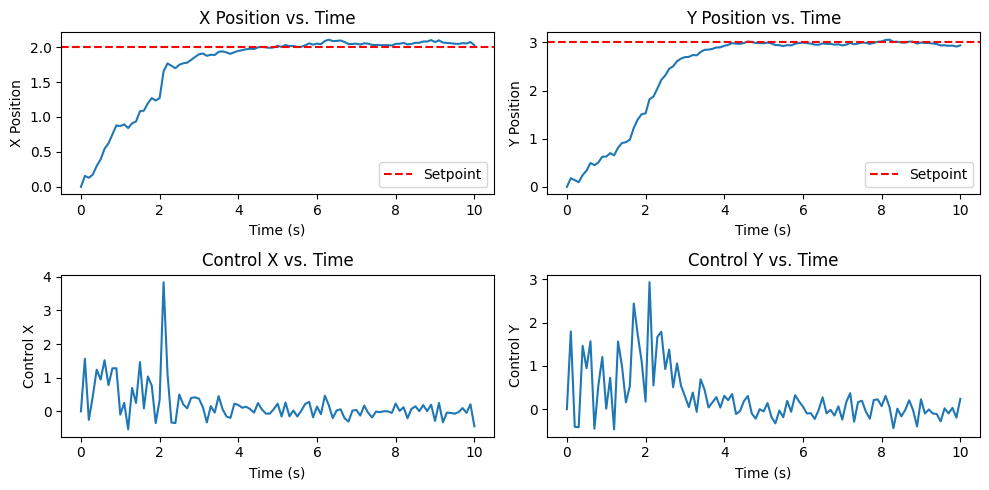

In [168]:
# Test Run 1
controller = MPPIController(100, 20, 0.1, 1.0, 0.1)
plot_traj(*run_simulation(controller, 10))

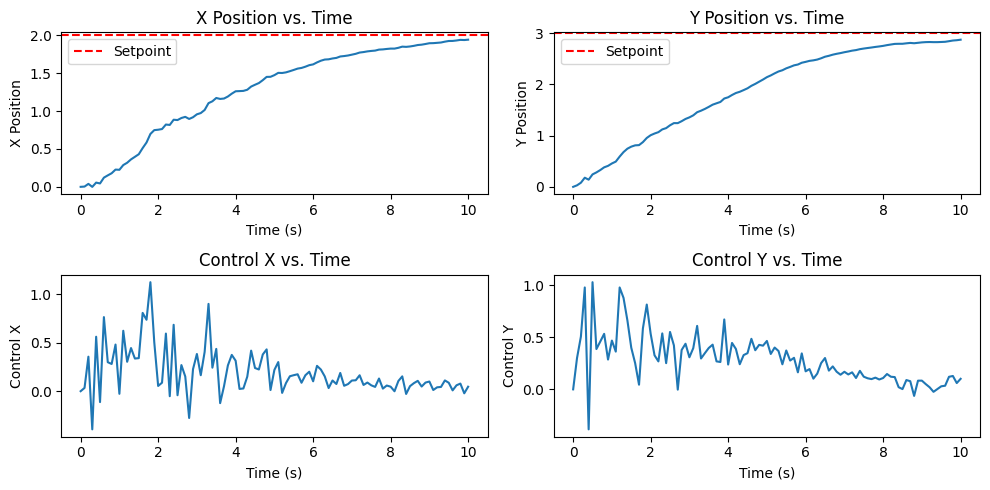

In [169]:
# Test Run slower control velocity in 10 secs
controller = MPPIController(100, 10, 0.1, 0.5, 0.1)
plot_traj(*run_simulation(controller, 10))

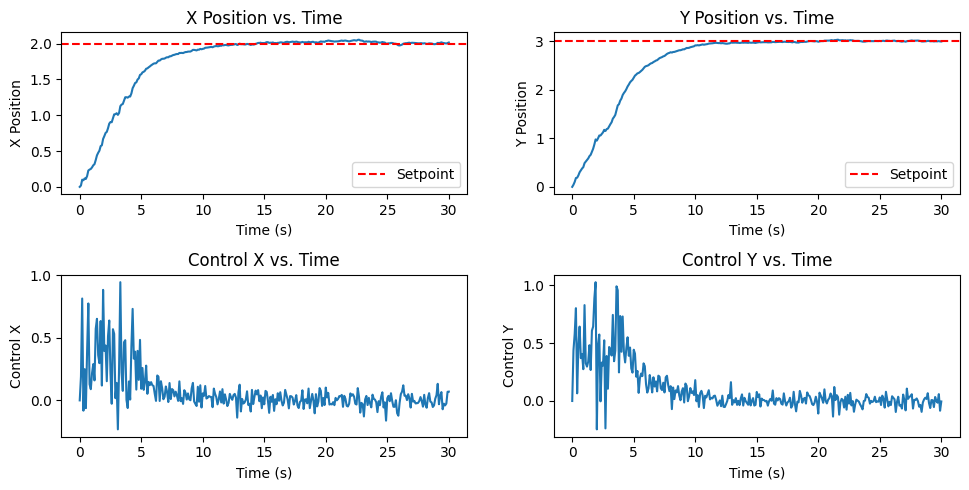

In [170]:
# Test Run with 30 secs
controller = MPPIController(100, 10, 0.1, 0.5, 0.1)
plot_traj(*run_simulation(controller, 30))